In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import scipy.sparse as sp
import math

from kuramoto import *
from wilson_cowan import *

import networkx as nx

from itertools import product

import pickle

from scipy.optimize import curve_fit

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

In [3]:
total_nodes = lambda hex_radius: 1 + 3*hex_radius + 3*hex_radius**2
total_edges = lambda hex_radius: 9*hex_radius*(hex_radius+1) - 6*hex_radius

In [4]:
[(n, total_nodes(n), total_edges(n)) for n in range(5)]

[(0, 1, 0), (1, 7, 12), (2, 19, 42), (3, 37, 90), (4, 61, 156)]

# Determining Parameters

Find a parameter regime that admits oscillations and is sensitive to adding random connections.

In [10]:
n = 4
N = total_nodes(n)
#m = 
coupling_coefficient = .3
wcn, edge_list, x_locations, y_locations = hex_network(n, coupling_weight=coupling_coefficient, random_edges=0)
# aE = .8
# θE = 2
# wcn.excitatory_firing_rate = lambda x: sigmoid(aE*(x - θE))
# aI = .8
# θI = 8
# wcn.inhibitory_firing_rate = lambda x: sigmoid(aI*(x - θI))

θE = -2
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

wcn.E0 = np.random.random(N)*.5
wcn.I0 = np.random.random(N)*.5


wcn.excitatory_variance = .01
wcn.inhibitory_variance = 0

print(get_network_statistics(edge_list))

(0.42290748898678415, 4.121311475409836, 8)


In [7]:
t_final = 20
time_span = (t_final/2, t_final)
ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
threshold_function=lambda x: np.quantile(x, .90)
window = 100
kuramoto = kuramoto_measure(ts, Es.T, threshold_function=threshold_function, window=window)
print(f'Kuramoto: {average_kuramoto(ts, Es.T, time_span=time_span, kuramoto=kuramoto)}')
print(f'Pearson: {pearson_mean(ts, Es, time_span=time_span)}')

Kuramoto: 0.6178625485856666
Pearson: 0.22388522625407745


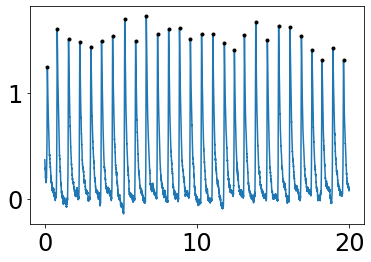

In [50]:
series = Es[:, 0]
spike_indices = get_spike_indices(ts, series, threshold_function=threshold_function, window=window)
plt.plot(ts, series)
plt.plot(ts[spike_indices], series[spike_indices], 'k.')

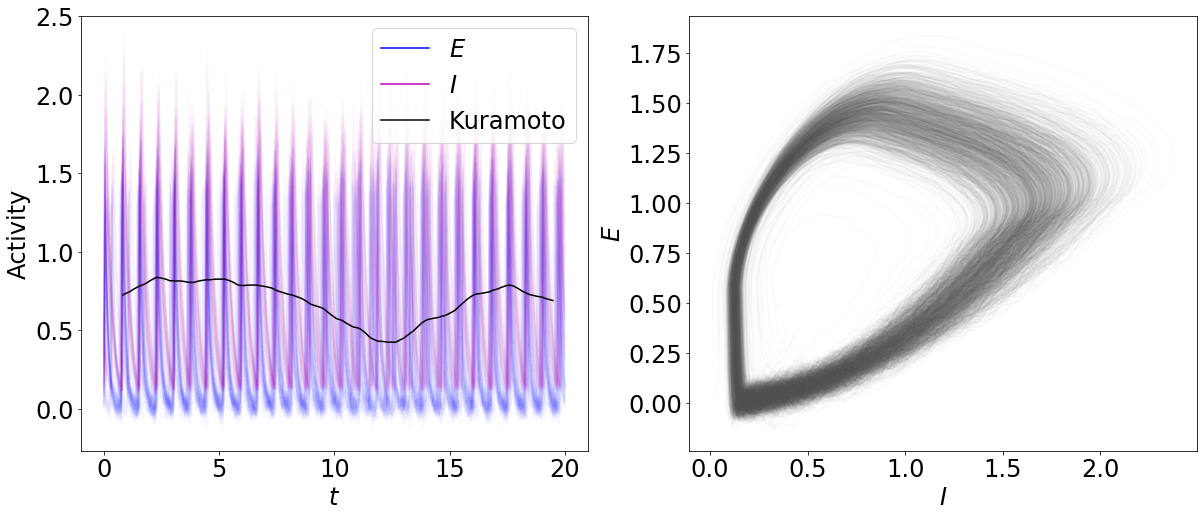

In [51]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/N)
plt.plot([], [], 'm-', label='$I$')
plt.plot(ts, kuramoto, 'k-', label='Kuramoto')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

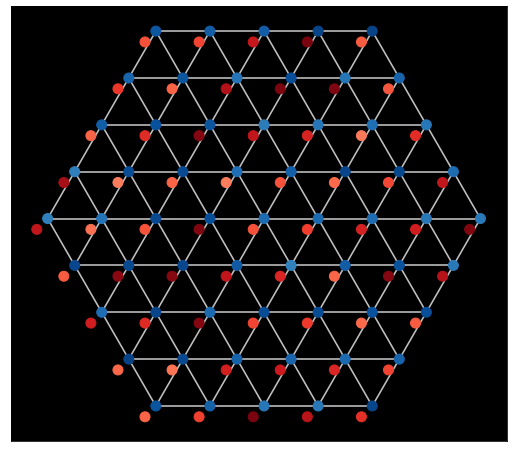

In [8]:
time_index = 1000

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])

x_locations = np.array(x_locations)
y_locations = np.array(y_locations)

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot([x_locations[node] for node in edge], [y_locations[node] for node in edge], 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 100
shift = .2
scatter_plot_inhibibory = ax.scatter(x_locations-shift, y_locations-shift, s=size, c=Is[time_index], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')
scatter_plot_excitatory = ax.scatter(x_locations, y_locations, s=size, c=Es[0], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')

# plt.tight_layout()

# plt.savefig('images/hex_lattice.png', bbox_inches='tight')

plt.show()
print()

In [53]:
frame_start = 0
frame_stop = len(ts)//2
frame_stride = 50

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])

x_locations = np.array(x_locations)
y_locations = np.array(y_locations)

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot([x_locations[node] for node in edge], [y_locations[node] for node in edge], 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shift = .2
scatter_plot_inhibibory = ax.scatter(x_locations-shift, y_locations-shift, s=size, c=Is[0], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')
scatter_plot_excitatory = ax.scatter(x_locations, y_locations, s=size, c=Es[0], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')


def animate(i):
    print(f'step {i}/{len(ts)}', end='\r')
    scatter_plot_excitatory.set_array(Es[i])
    scatter_plot_inhibibory.set_array(Is[i])
    return scatter_plot_excitatory,


# Init only required for blitting to give a clean slate.
def init():
    scatter_plot_excitatory.set_array(Es[0])
    scatter_plot_inhibibory.set_array(Is[0])
    return scatter_plot_excitatory,

anim = animation.FuncAnimation(fig, animate, np.arange(frame_start,frame_stop,frame_stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('PE_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

0.42290748898678415 4.121311475409836 8


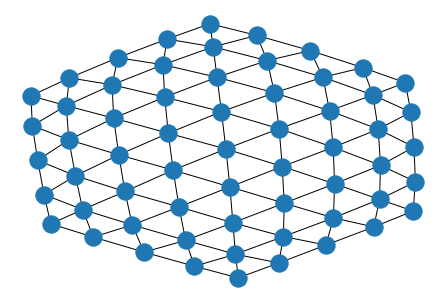

In [11]:
G = nx.convert.from_edgelist(edge_list)
nx.draw(G)
clustering_coeff = nx.transitivity(G)
mean_path_length = nx.average_shortest_path_length(G)
diameter = nx.networkx.algorithms.distance_measures.diameter(G)
print(clustering_coeff, mean_path_length, diameter)

In [9]:
def get_network_statistics(edge_list):
    G = nx.convert.from_edgelist(edge_list)
    clustering_coeff = nx.transitivity(G)
    mean_path_length = nx.average_shortest_path_length(G)
    diameter = nx.networkx.algorithms.distance_measures.diameter(G)
    return clustering_coeff, mean_path_length, diameter

In [56]:
kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
pearson = pearson_mean(ts, Es, time_span=time_span)
clustering_coefficient, mean_path_length, daimeter = get_network_statistics(edge_list)

print(kuramoto, pearson, clustering_coefficient, mean_path_length, diameter)

0.6104372725780851 0.22667118591363528 0.42290748898678415 4.121311475409836 8


# Setup and Run Experiments

In [13]:
def get_network_statistics(edge_list):
    G = nx.convert.from_edgelist(edge_list)
    clustering_coeff = nx.transitivity(G)
    mean_path_length = nx.average_shortest_path_length(G)
    diameter = nx.networkx.algorithms.distance_measures.diameter(G)
    return clustering_coeff, mean_path_length, diameter

def initialize_model(n, random_edges, variance, coupling_coefficient):
    N = total_nodes(n)
    m = total_edges(n)
    wcn, edge_list, x_locations, y_locations = hex_network(n, coupling_weight=coupling_coefficient, random_edges=random_edges)

    θE = -2
    θI = 8
    wcn.excitatory_firing_rate = lambda x: relu(x - θE)
    wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

    wcn.E0 = np.random.random(N)*.5
    wcn.I0 = np.random.random(N)*.5


    wcn.excitatory_variance = variance
    wcn.inhibitory_variance = 0
    
    return wcn, edge_list

In [14]:
ns = [4]
random_edges_list = [0, 1, 2, 5, 10, 20, 40, 50, 'max']
variances = [0.01]
coupling_coefficients = [0.3]
trials = 500

t_final = 50
time_span = (t_final/2, t_final)

num_experiments = len(list(product(ns, random_edges_list, variances, coupling_coefficients, range(trials))))
results_key = [
    'experiment_index', 
    'trial',
    'n',
    'random_edges', 
    'variance',
    'coupling_coefficient',
    'kuramoto',
    'pearson',
    'clustering_coefficient',
    'mean_path_length',
    'diameter'
]
print(num_experiments)

4500


In [7]:
results = []
errors_list = []
for experiment_index, (n, random_edges, variance, coupling_coefficient, trial) \
        in enumerate(product(ns, random_edges_list, variances, coupling_coefficients, range(trials))):
    print(f'{experiment_index+1}/{num_experiments}' + ' '*100, end='\r')
    N = total_nodes(n)
    m = total_edges(n)
    if random_edges is 'max':
        random_edges = m
    elif random_edges >= m:
        errors_list.append(experiment_index)
        continue #skip if too many random edges
    valid = False
    while not valid:
        try:
            wcn, edge_list = initialize_model(n, random_edges, variance, coupling_coefficient)
            clustering_coefficient, mean_path_length, diameter = get_network_statistics(edge_list)
            ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
            kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
            pearson = pearson_mean(ts, Es, time_span=time_span)
            result = (
                experiment_index, 
                trial,
                n,
                random_edges, 
                variance,
                coupling_coefficient,
                kuramoto,
                pearson,
                clustering_coefficient,
                mean_path_length,
                diameter
            )
            valid = True
        except:
            pass
            
    results.append(result)
    with open(f'raw_data/experiment04/index{experiment_index}.pickle', 'wb') as f:
        pickle.dump(result, f)
with open(f'raw_data/experiment04/errors.pickle', 'wb') as f:
    pickle.dump(errors_list, f)
print('complete' + ' '*100)

complete                                                                                                     


In [108]:
# loading after abort
# skipped = []
# results = []
# for experiment_index in range(num_experiments):
#     try:
#         with open(f'raw_data/experiment02/index{experiment_index}.pickle', 'rb') as f:
#             result = pickle.load(f)
#             results.append(result)
#     except:
#         skipped.append(experiment_index)
        
# print('results loaded')

### Load experiments

In [15]:
# results = []
# with open(f'raw_data/experiment04/errors.pickle', 'rb') as f:
#     errors_list = pickle.load(f)
    
# print(errors_list)

# for experiment_index in range(num_experiments):
#     if experiment_index in errors_list:
#         continue
#     with open(f'raw_data/experiment04/index{experiment_index}.pickle', 'rb') as f:
#         result = pickle.load(f)
#         results.append(result)
        
# print('results loaded')

[]
results loaded


# Results

In [18]:
def bins_and_averages(xs, ys, n=20):
    xs = np.array(xs)
    ys = np.array(ys)
    lower, upper = np.min(xs), np.max(xs)
    bin_boundaries = np.linspace(lower, upper, n+1)
    bin_centers = (bin_boundaries[1:] + bin_boundaries[:-1])/2
    means = []
    Q1s = []
    Q3s = []
    for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        mask = np.logical_and(xs >= lower, xs <=upper)
        data = ys[mask]
        means.append(np.mean(data))
        Q1s.append(np.quantile(data, .25))
        Q3s.append(np.quantile(data, .75))
    return bin_centers, means, Q1s, Q3s

In [19]:
n_index = results_key.index('n')
variance_index = results_key.index('variance')
coupling_coefficient_index = results_key.index('coupling_coefficient')
kuramoto_index = results_key.index('kuramoto')
pearson_index = results_key.index('pearson')
mean_path_index = results_key.index('mean_path_length')
diameter_index = results_key.index('diameter')
clustering_coefficient_index = results_key.index('clustering_coefficient')
def result_filter(result):
    condition = True
    return condition

kuramoto_list = [result[kuramoto_index] for result in results if result_filter(result)]
pearson_list = [result[pearson_index] for result in results if result_filter(result)]
mean_path_list = [result[mean_path_index] for result in results if result_filter(result)]
clustering_coefficient_list = [result[clustering_coefficient_index] for result in results if result_filter(result)]
diameter_list = [result[diameter_index] for result in results if result_filter(result)]

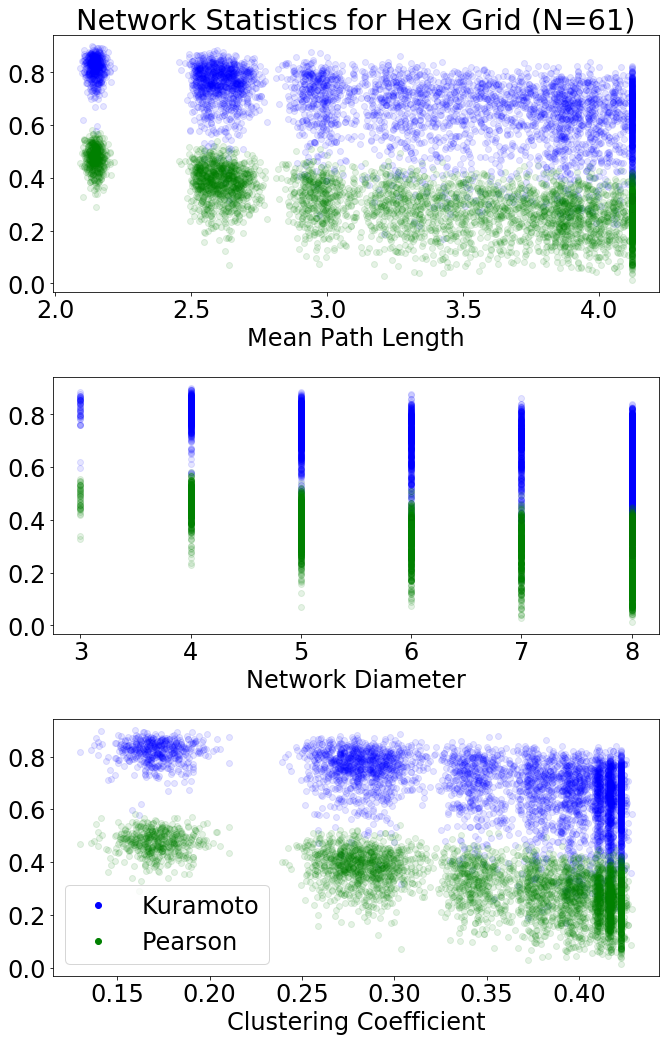

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

alpha = 0.1

axes[0].plot(mean_path_list, kuramoto_list, 'bo', label='Kuramoto', alpha=alpha)
axes[0].plot(mean_path_list, pearson_list, 'go', label='Pearson', alpha=alpha)
axes[0].set_xlabel('Mean Path Length')
# plt.ylabel('Synchrony')
# plt.legend()
# plt.show()

# fig = plt.figure(figsize=(10, 5))
axes[1].plot(diameter_list, kuramoto_list, 'bo', label='Kuramoto', alpha=alpha)
axes[1].plot(diameter_list, pearson_list, 'go', label='Pearson', alpha=alpha)
axes[1].set_xlabel('Network Diameter')
# plt.ylabel('Synchrony')
# plt.legend()
# plt.show()

# fig = plt.figure(figsize=(10, 5))
axes[2].plot(clustering_coefficient_list, kuramoto_list, 'bo', alpha=alpha)
axes[2].plot(clustering_coefficient_list, pearson_list, 'go', alpha=alpha)
axes[2].plot([], [], 'bo', label='Kuramoto', alpha=1)
axes[2].plot([], [], 'go', label='Pearson', alpha=1)
axes[2].set_xlabel('Clustering Coefficient')
# plt.ylabel('Synchrony')

axes[0].set_title('Network Statistics for Hex Grid (N=61)')

plt.legend()

plt.tight_layout()

# plt.savefig('images/hex_raw.png')

plt.show()

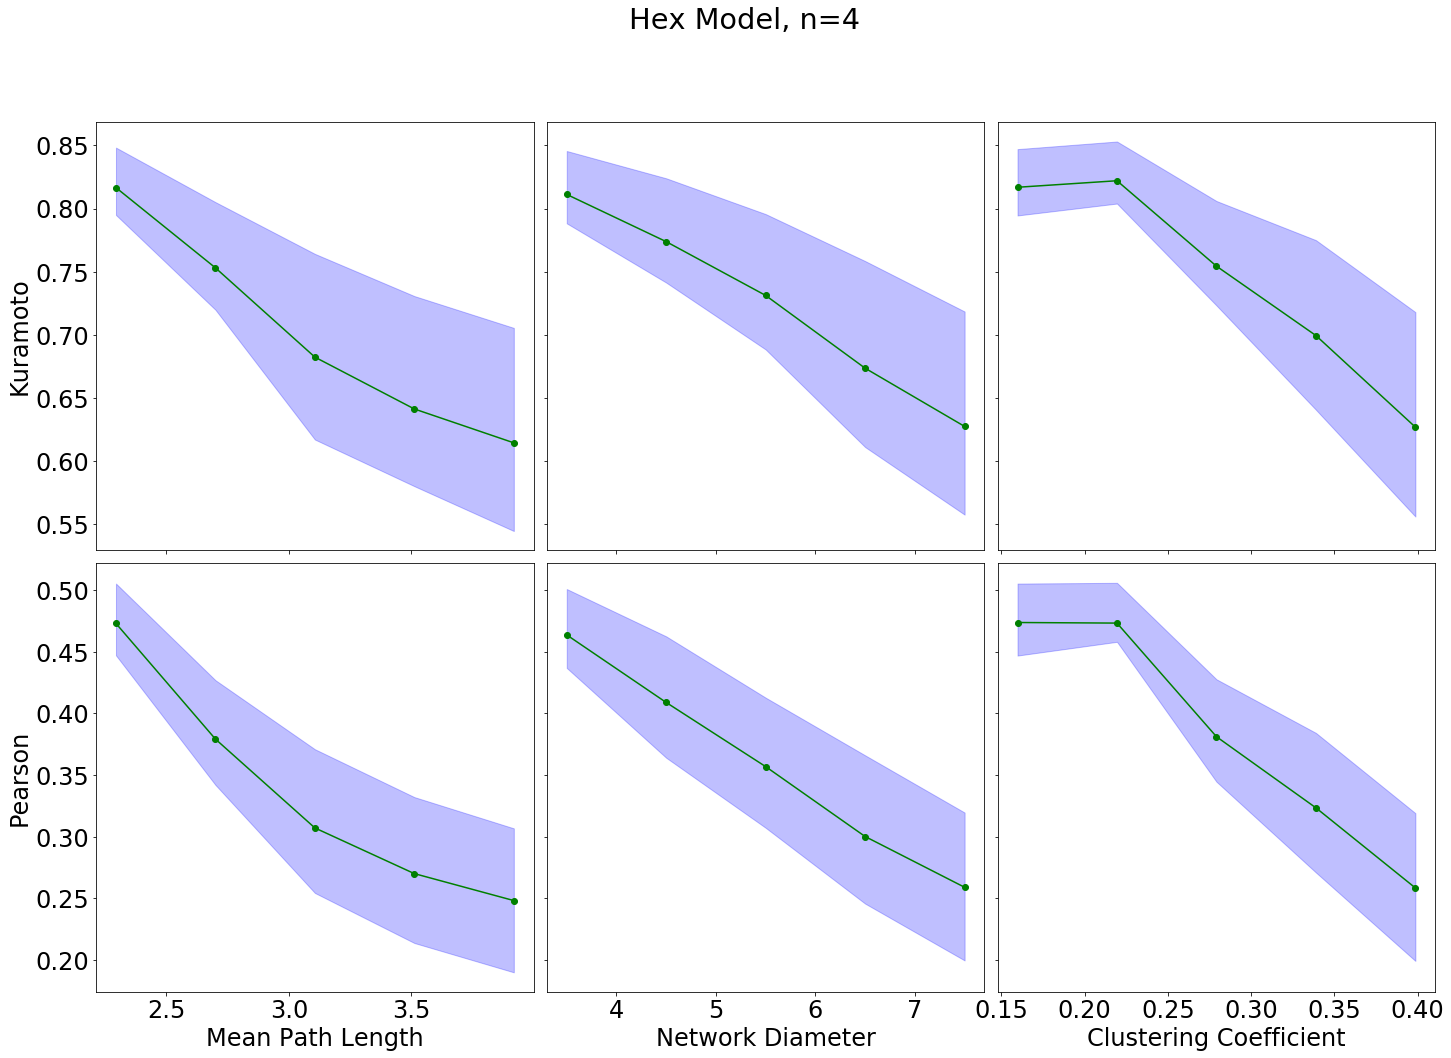

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharey='row', sharex='col')
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for row, y_var in enumerate([kuramoto_list, pearson_list]):
    for col, x_var in enumerate([mean_path_list, diameter_list, clustering_coefficient_list]):
        bin_centers, means, Q1s, Q3s = bins_and_averages(x_var, y_var, n=5)
        axes[row][col].plot(bin_centers, means, 'go-', label='Mean')
        axes[row][col].fill_between(bin_centers, Q1s, Q3s, alpha=.25, label='IQR', color='b')
        
for col, label in enumerate(['Mean Path Length', 'Network Diameter', 'Clustering Coefficient']):
    axes[-1][col].set_xlabel(label)
    
for row, label in enumerate(['Kuramoto', 'Pearson']):
    axes[row][0].set_ylabel(label)
    
plt.suptitle('Hex Model, n=4')

# plt.tight_layout()

# plt.savefig('images/summary_stats_hex.png')
        
plt.show()

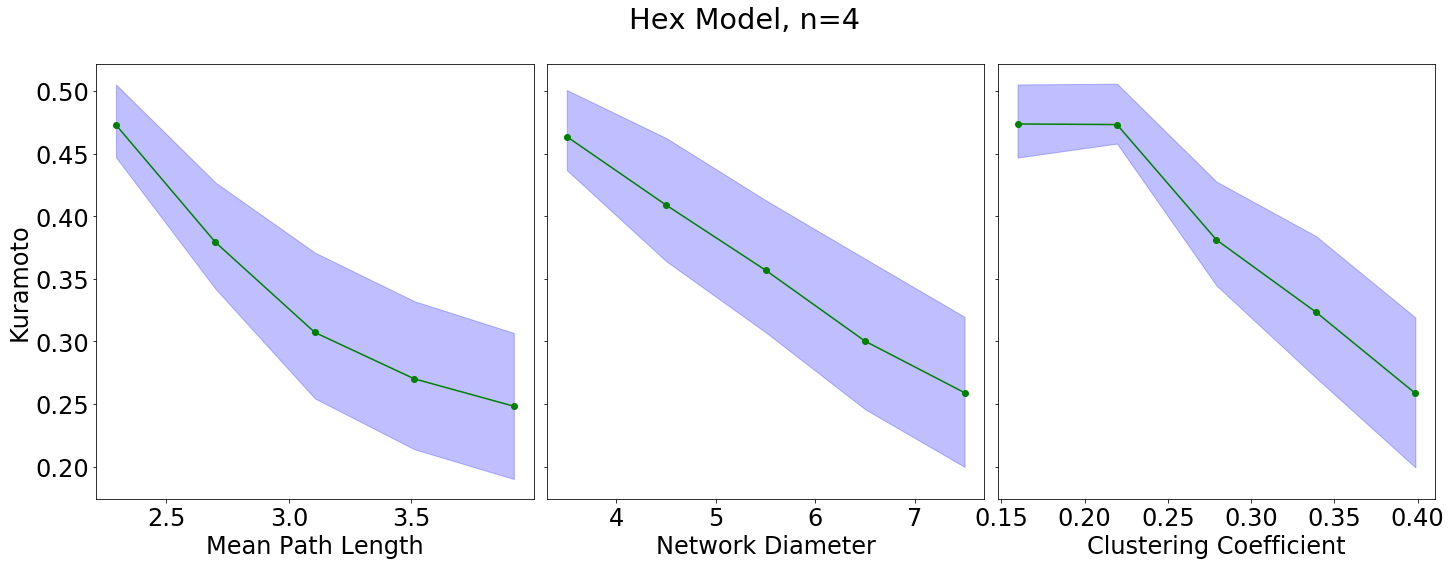

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey='row', sharex='col')
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for col, x_var in enumerate([mean_path_list, diameter_list, clustering_coefficient_list]):
    bin_centers, means, Q1s, Q3s = bins_and_averages(x_var, y_var, n=5)
    axes[col].plot(bin_centers, means, 'go-', label='Mean')
    axes[col].fill_between(bin_centers, Q1s, Q3s, alpha=.25, label='IQR', color='b')
        
for col, label in enumerate(['Mean Path Length', 'Network Diameter', 'Clustering Coefficient']):
    axes[col].set_xlabel(label)
    
axes[0].set_ylabel('Kuramoto')
    
plt.suptitle('Hex Model, n=4')

# plt.tight_layout()

plt.savefig('images/summary_stats_hex.png')
        
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


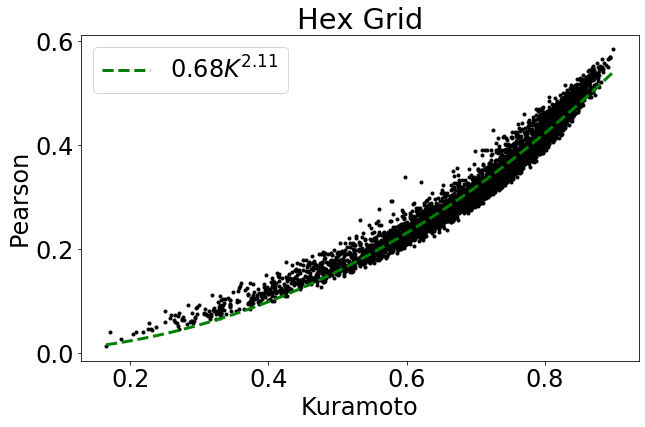

In [38]:
kuramoto_list = [result[kuramoto_index] for result in results]
pearson_list = [result[pearson_index] for result in results]

def model(x, a, b):
    return a*x**b

a, b = curve_fit(model, kuramoto_list, pearson_list)[0]

xs = np.linspace(min(kuramoto_list), max(kuramoto_list), 201)

plt.figure(figsize=(10,6))
plt.plot(kuramoto_list, pearson_list, 'k.')
plt.plot(xs, a*xs**b, 'g--', linewidth=3, label=f'${a:.2f}K^{{{b:.2f}}}$')
plt.xlabel('Kuramoto')
plt.ylabel('Pearson')
plt.title('Hex Grid')
plt.legend()

# plt.savefig('images/hex_synchrony_equivalence.eps')

plt.show()

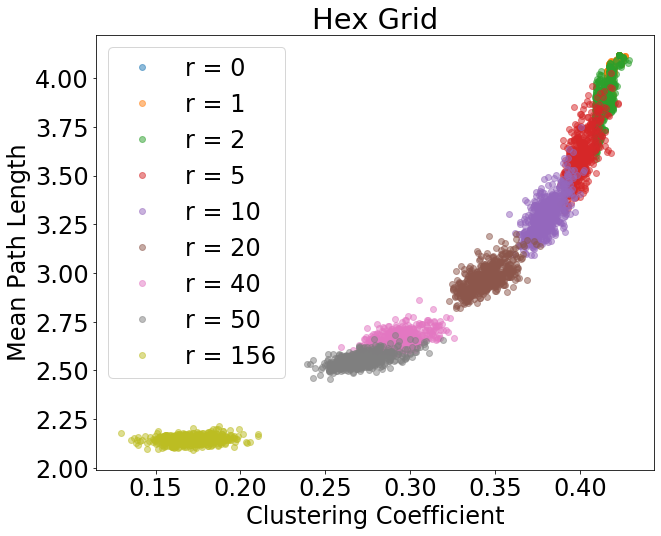

In [39]:
num_edges_index = results_key.index('random_edges')

plt.figure(figsize=(10, 8))
for num_edges in random_edges_list:
    if num_edges == 'max':
        num_edges = m
    def test_filter(result, num_edges):
        return result[num_edges_index] == num_edges
    filtered_clustering_coeff = [result[clustering_coefficient_index] for result in results if test_filter(result, num_edges)]
    filtered_mean_path_legth = [result[mean_path_index] for result in results if test_filter(result, num_edges)]
    plt.plot(filtered_clustering_coeff, filtered_mean_path_legth, 'o', alpha=.5, label=f'r = {num_edges}')
    
plt.xlabel('Clustering Coefficient')
plt.ylabel('Mean Path Length')
plt.legend()

plt.title('Hex Grid')

plt.savefig('images/hex_clustering_mean_path.png')

plt.show()

# Summary stats and raw data

In [20]:
def summary_stats(xs, ys, n=20, bin_centers=None):
    xs = np.array(xs)
    ys = np.array(ys)
    if bin_centers is None:
        lower, upper = np.min(xs), np.max(xs)
        bin_boundaries = np.linspace(lower, upper, n+1)
        bin_centers = (bin_boundaries[1:] + bin_boundaries[:-1])/2
    else:
        bin_centers = np.array(bin_centers)
        bin_boundaries = np.zeros(len(bin_centers)+1)
        bin_boundaries[0] = bin_centers[0]-1
        bin_boundaries[-1] = bin_centers[-1]+1
        bin_boundaries[1:-1] = (bin_centers[1:] + bin_centers[:-1])/2
    means = []
    Q1s = []
    Q3s = []
    for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        mask = np.logical_and(xs >= lower, xs <=upper)
        data = ys[mask]
        means.append(np.mean(data))
        Q1s.append(np.quantile(data, .25))
        Q3s.append(np.quantile(data, .75))
    return bin_centers, means, Q1s, Q3s

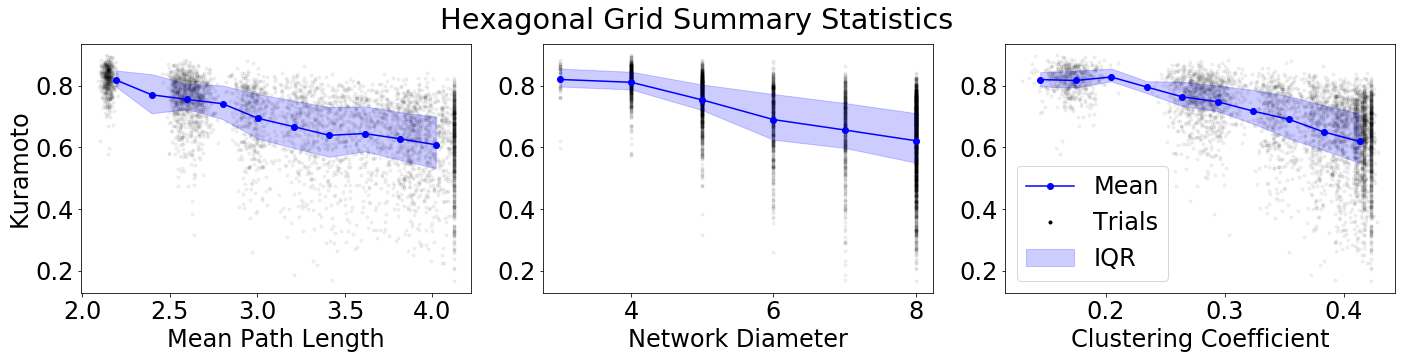

In [22]:
data_and_labels = [
    (mean_path_list, 'Mean Path Length'),
    (diameter_list, 'Network Diameter'),
    (clustering_coefficient_list, 'Clustering Coefficient')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for col, (data, label) in enumerate(data_and_labels):
    if label == 'Network Diameter':
        bin_centers, means, Q1s, Q3s = summary_stats(data, kuramoto_list, bin_centers = list(set(data)))
    else:
        bin_centers, means, Q1s, Q3s = bins_and_averages(data, kuramoto_list, n=10)
    axes[col].plot(data, kuramoto_list, 'k.', alpha = 0.05, zorder=0)
    axes[col].plot(bin_centers, means, 'bo-', label='Mean', zorder=2)
    axes[col].fill_between(bin_centers, Q1s, Q3s, alpha=.2, label='IQR', color='b', zorder=1)
    axes[col].set_xlabel(label)
axes[0].set_ylabel('Kuramoto')

axes[-1].plot([], [], 'k.', label='Trials')
axes[-1].legend()

plt.suptitle('Hexagonal Grid Summary Statistics ', y=1.03)


plt.tight_layout()

# plt.savefig('images/summary_stats_hex.png', bbox_inches='tight')

plt.show()